In [1]:
# 2.1.6버전이 아닐경우, rank error 발생..
!pip install --upgrade keras==2.1.6

  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [2]:
from __future__ import division
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
import pickle
from optparse import OptionParser
import time
from keras_frcnn import config
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras_frcnn import roi_helpers
import keras
print(keras.__version__)
%matplotlib inline

Using TensorFlow backend.


2.1.6


In [3]:
# C = config file
with open('config.pickle', 'rb') as f_in:
    C = pickle.load(f_in)
print(C.network)

if C.network == 'resnet50':
    import keras_frcnn.resnet as nn
elif C.network == 'vgg':
    import keras_frcnn.vgg as nn
    
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

resnet50


In [4]:
type(C)

keras_frcnn.config.Config

In [5]:
# 변수 선언
class_mapping = C.class_mapping

In [6]:
# 확인
class_mapping

{'sheep': 13,
 'horse': 9,
 'bg': 20,
 'bicycle': 4,
 'motorbike': 11,
 'cow': 19,
 'sofa': 8,
 'bus': 0,
 'aeroplane': 16,
 'dog': 3,
 'cat': 12,
 'person': 2,
 'train': 18,
 'boat': 10,
 'bottle': 7,
 'car': 1,
 'pottedplant': 14,
 'tvmonitor': 15,
 'chair': 5,
 'bird': 17,
 'diningtable': 6}

In [7]:
# 확인
class_mapping.items()

dict_items([('sheep', 13), ('horse', 9), ('bg', 20), ('bicycle', 4), ('motorbike', 11), ('cow', 19), ('sofa', 8), ('bus', 0), ('aeroplane', 16), ('dog', 3), ('cat', 12), ('person', 2), ('train', 18), ('boat', 10), ('bottle', 7), ('car', 1), ('pottedplant', 14), ('tvmonitor', 15), ('chair', 5), ('bird', 17), ('diningtable', 6)])

In [8]:
# class_mapping의 key, value의 구성을 바꿈
class_mapping = {v: k for k, v in class_mapping.items()}

In [9]:
# 확인
class_mapping

{13: 'sheep',
 9: 'horse',
 20: 'bg',
 4: 'bicycle',
 11: 'motorbike',
 19: 'cow',
 8: 'sofa',
 0: 'bus',
 16: 'aeroplane',
 3: 'dog',
 12: 'cat',
 2: 'person',
 18: 'train',
 10: 'boat',
 7: 'bottle',
 1: 'car',
 14: 'pottedplant',
 15: 'tvmonitor',
 5: 'chair',
 17: 'bird',
 6: 'diningtable'}

In [10]:
# 물체 하나 하나당 고유의 rgb값을 가지게해서 최종 출력할때 사용
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

In [11]:
# 확인
class_to_color

{'sheep': array([218, 111,  64]),
 'horse': array([ 75,  31, 151]),
 'bg': array([ 94,  31, 140]),
 'bicycle': array([148,  70, 157]),
 'motorbike': array([179,  44, 123]),
 'cow': array([133,  50, 175]),
 'sofa': array([ 41,  89, 222]),
 'bus': array([228, 111,  76]),
 'aeroplane': array([ 43,  92, 207]),
 'dog': array([243, 153, 193]),
 'cat': array([ 25,  86, 197]),
 'person': array([163, 190, 156]),
 'train': array([136,  36, 112]),
 'boat': array([243,  42,  91]),
 'bottle': array([ 13, 217, 186]),
 'car': array([131,  10,   5]),
 'pottedplant': array([ 88, 127,  72]),
 'tvmonitor': array([ 97,  81, 249]),
 'chair': array([62, 57, 80]),
 'bird': array([153, 148, 126]),
 'diningtable': array([234, 174,  89])}

In [12]:
# num_rois : roi의 개수를 뜻함.
C.num_rois = int(32)

In [13]:
if C.network == 'resnet50':
    num_features = 1024
elif C.network == 'vgg':
    num_features = 512
print(num_features)

1024


In [14]:
K

<module 'keras.backend' from 'C:\\Users\\jungg\\Anaconda3\\lib\\site-packages\\keras\\backend\\__init__.py'>

In [15]:
if K.common.image_dim_ordering() == 'th': # -> 케라스에서 theano backend를 사용한다는 것을 뜻함.
    input_shape_img = (3, None, None)
    input_shape_features = (num_features, None, None)
else: # tensorflow backend를 사용하기 때문에 선택됨.
    input_shape_img = (None, None, 3)
    input_shape_features = (None, None, num_features)

In [16]:
# confirm
input_shape_img

(None, None, 3)

In [17]:
# confirm
input_shape_features

(None, None, 1024)

In [18]:
# 모델에 들어갈 input 정의
img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

In [19]:
# confirm
img_input

<tf.Tensor 'input_1:0' shape=(?, ?, ?, 3) dtype=float32>

In [20]:
# confirm
roi_input

<tf.Tensor 'input_2:0' shape=(?, 32, 4) dtype=float32>

In [21]:
# confirm
feature_map_input

<tf.Tensor 'input_3:0' shape=(?, ?, ?, 1024) dtype=float32>

In [22]:
# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn.nn_base(img_input, trainable=True)

Instructions for updating:
Colocations handled automatically by placer.


In [23]:
# confirm
shared_layers

<tf.Tensor 'activation_40/Relu:0' shape=(?, ?, ?, 1024) dtype=float32>

In [24]:
# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
print('ancor 갯수 ',num_anchors)

ancor 갯수  9


In [25]:
rpn_layers = nn.rpn(shared_layers, num_anchors)

In [26]:
# confirm
rpn_layers

[<tf.Tensor 'rpn_out_class/Sigmoid:0' shape=(?, ?, ?, 9) dtype=float32>,
 <tf.Tensor 'rpn_out_regress/BiasAdd:0' shape=(?, ?, ?, 36) dtype=float32>,
 <tf.Tensor 'activation_40/Relu:0' shape=(?, ?, ?, 1024) dtype=float32>]

In [27]:
classifier = nn.classifier(feature_map_input, roi_input, C.num_rois, nb_classes=len(class_mapping), trainable=True)

In [28]:
# confirm
classifier

[<tf.Tensor 'dense_class_21/Reshape_1:0' shape=(1, 32, 21) dtype=float32>,
 <tf.Tensor 'dense_regress_21/Reshape_1:0' shape=(1, 32, 80) dtype=float32>]

In [29]:
model_rpn = Model(input=img_input, output=rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)
model_classifier = Model([feature_map_input, roi_input], classifier)

C:\Users\jungg\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`
  """Entry point for launching an IPython kernel.


In [30]:
print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

Loading weights from ./model_frcnn.hdf5


In [31]:
model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

In [33]:
#!pip install pydot

In [35]:
# import keras
# import pydot as pyd
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# keras.utils.vis_utils.pydot = pyd

# #Visualize Model
# #create your model
# #then call the function on your model

# SVG(model_to_dot(model_rpn,show_shapes=True).create(prog='dot', format='svg'))

# from keras.utils import plot_model
# plot_model(model_rpn, to_file='non_resnet+rpn_model.png',show_shapes=True)
# plot_model(model_classifier, to_file='non_classifier_model.png',show_shapes=True)

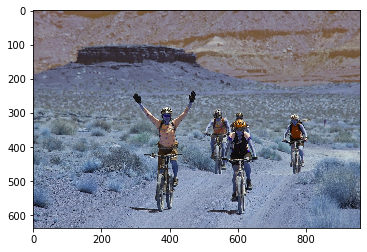

(638, 960, 3)
resize 전 (638, 960, 3)
resize 후 (1, 3, 600, 902)
전/후 ratio 값 0.9404388714733543
scaler 전 [127 106 105]
scaler 후 1.060997 -10.778999 3.3199997
(1, 600, 902, 3)


In [36]:
##### predict start #####
img_path = 'bicycles.jpg'
img = cv2.imread(img_path)
plt.imshow(img)
plt.show()
print(img.shape)

###################### 이미지 전처리 #######################
# resize + scaler
def format_img_size(img, C):
    """ formats the image size based on config """
    img_min_side = float(C.im_size)
    (height,width,_) = img.shape
    if width <= height:
        ratio = img_min_side/width
        new_height = int(ratio * height)
        new_width = int(img_min_side)
    else:
        ratio = img_min_side/height
        new_width = int(ratio * width)
        new_height = int(img_min_side)
    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    return img, ratio

def format_img_channels(img, C):
    """ formats the image channels based on config """
    img = img[:, :, (2, 1, 0)]
    img = img.astype(np.float32)
    img[:, :, 0] -= C.img_channel_mean[0]
    img[:, :, 1] -= C.img_channel_mean[1]
    img[:, :, 2] -= C.img_channel_mean[2]
    img /= C.img_scaling_factor
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)
    return img

def format_img(img, C):
    """ formats an image for model prediction based on config """
    img, ratio = format_img_size(img, C)
    img = format_img_channels(img, C)
    return img, ratio

X, ratio = format_img(img, C)
print('resize 전',img.shape)
print('resize 후',X.shape)
print('전/후 ratio 값',ratio)

# format_img_size + format_img_channels = format_img
# resize : 638,960 > 600,902 + ratio = 0.9404388714733543 + std
# 픽셀값들을 전처리 
# img_scaling_factor = 1.0 , img_channel_mean = [103.939, 116.779, 123.68]

print('scaler 전',img[0][0])
print('scaler 후',X[0][0][0][0],X[0][1][0][0],X[0][2][0][0])

if K.image_dim_ordering() == 'tf':
    X = np.transpose(X, (0, 2, 3, 1))
print(X.shape)

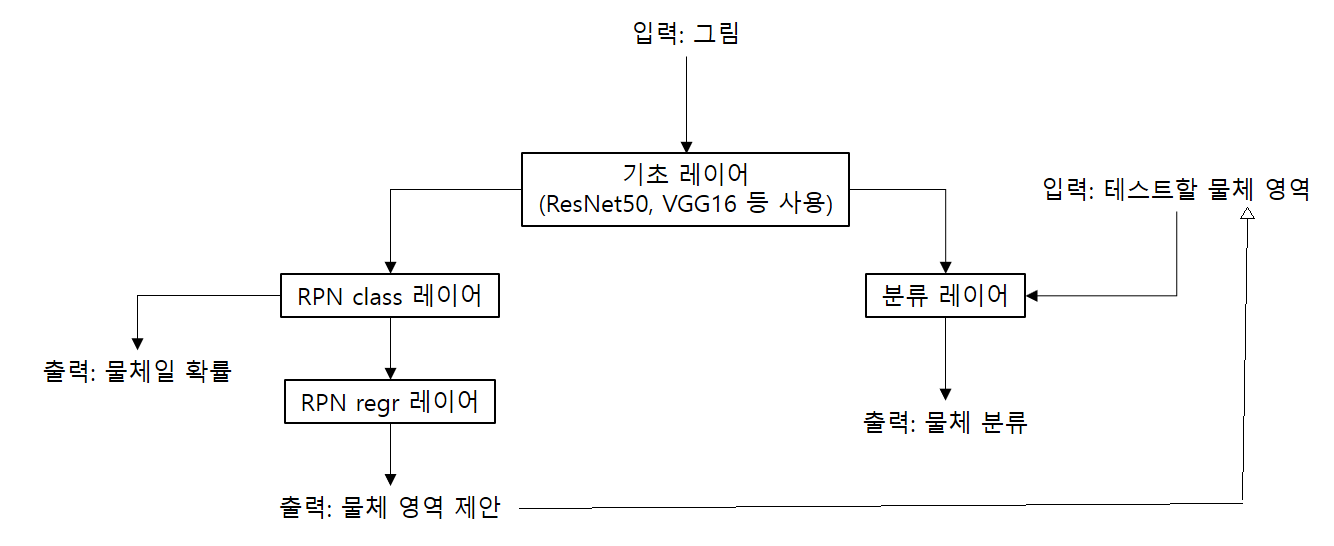

In [37]:
# 전처리된 이미지로 앞서 선언한 RPN 모델 실행
[Y1, Y2, F] = model_rpn.predict(X)
print(Y1.shape) # 물체일 확률, 제안값
print(Y2.shape) # roi (x1,y1,x2,y2) 물체영역 제안 
# 제안값 + 물체영역으로 높은 확률의 roi만 가져온다.
print(F.shape) # 특성맵

(1, 38, 57, 9)
(1, 38, 57, 36)
(1, 38, 57, 1024)


In [38]:
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
    # code used from here: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    np.testing.assert_array_less(x1, x2)
    np.testing.assert_array_less(y1, y2)

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # calculate the areas
    area = (x2 - x1) * (y2 - y1)

    # sort the bounding boxes 
    idxs = np.argsort(probs)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the intersection

        xx1_int = np.maximum(x1[i], x1[idxs[:last]])
        yy1_int = np.maximum(y1[i], y1[idxs[:last]])
        xx2_int = np.minimum(x2[i], x2[idxs[:last]])
        yy2_int = np.minimum(y2[i], y2[idxs[:last]])

        ww_int = np.maximum(0, xx2_int - xx1_int)
        hh_int = np.maximum(0, yy2_int - yy1_int)

        area_int = ww_int * hh_int

        # find the union
        area_union = area[i] + area[idxs[:last]] - area_int

        # compute the ratio of overlap
        overlap = area_int/(area_union + 1e-6)

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],np.where(overlap > overlap_thresh)[0])))

        if len(pick) >= max_boxes:
            break

    # return only the bounding boxes that were picked using the integer data type
    boxes = boxes[pick].astype("int")
    probs = probs[pick]
    return boxes, probs

8.0 8.0
[-4.  0.  0.  0.  0.  0.  0.  0.  0.]
[-3.  0.  0.  0.  0.  0.  0.  0.  0.]
8.0 16.0
[ 0. -4.  0.  0.  0.  0.  0.  0.  0.]
[ 0. -4.  0.  0.  0.  0.  0.  0.  0.]
16.0 8.0
[ 0.  0. -8.  0.  0.  0.  0.  0.  0.]
[ 0.  0. -5.  0.  0.  0.  0.  0.  0.]
16.0 16.0
[ 0.  0.  0. -8.  0.  0.  0.  0.  0.]
[ 0.  0.  0. -9.  0.  0.  0.  0.  0.]
16.0 32.0
[ 0.  0.  0.  0. -8.  0.  0.  0.  0.]
[  0.   0.   0.   0. -11.   0.   0.   0.   0.]
32.0 16.0
[  0.   0.   0.   0.   0. -16.   0.   0.   0.]
[  0.   0.   0.   0.   0. -15.   0.   0.   0.]
32.0 32.0
[  0.   0.   0.   0.   0.   0. -16.   0.   0.]
[  0.   0.   0.   0.   0.   0. -19.   0.   0.]
32.0 64.0
[  0.   0.   0.   0.   0.   0.   0. -16.   0.]
[  0.   0.   0.   0.   0.   0.   0. -23.   0.]
64.0 32.0
[  0.   0.   0.   0.   0.   0.   0.   0. -32.]
[  0.   0.   0.   0.   0.   0.   0.   0. -35.]
19494
(19462,)


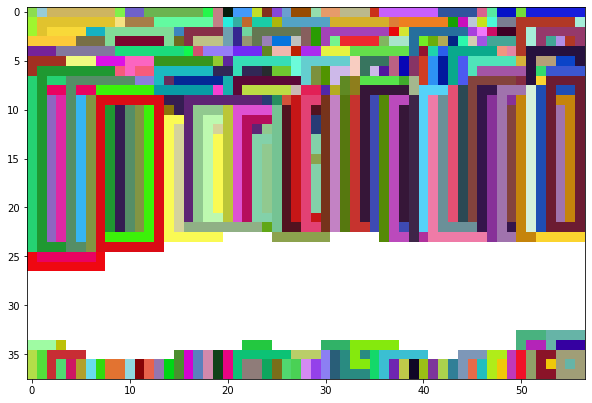

In [39]:
def apply_regr_np(X, T):
    try:
        x = X[0, :, :]
        y = X[1, :, :]
        w = X[2, :, :]
        h = X[3, :, :]

        tx = T[0, :, :]
        ty = T[1, :, :]
        tw = T[2, :, :]
        th = T[3, :, :]

        cx = x + w/2.
        cy = y + h/2.
        cx1 = tx * w + cx
        cy1 = ty * h + cy

        w1 = np.exp(tw.astype(np.float64)) * w
        h1 = np.exp(th.astype(np.float64)) * h
        x1 = cx1 - w1/2.
        y1 = cy1 - h1/2.

        x1 = np.round(x1)
        y1 = np.round(y1)
        w1 = np.round(w1)
        h1 = np.round(h1)
        return np.stack([x1, y1, w1, h1])
    except Exception as e:
        print(e)
        return X
    
def rpn_to_roi1(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=300,overlap_thresh=0.9):
    # 왜하는거임
    regr_layer = regr_layer / C.std_scaling

    anchor_sizes = C.anchor_box_scales
    anchor_ratios = C.anchor_box_ratios

    assert rpn_layer.shape[0] == 1

    if dim_ordering == 'th':
        (rows,cols) = rpn_layer.shape[2:]

    elif dim_ordering == 'tf':
        (rows, cols) = rpn_layer.shape[1:3]

    curr_layer = 0
    if dim_ordering == 'tf':
        A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))
    elif dim_ordering == 'th':
        A = np.zeros((4, rpn_layer.shape[2], rpn_layer.shape[3], rpn_layer.shape[1]))

    for anchor_size in anchor_sizes:
        for anchor_ratio in anchor_ratios:

            anchor_x = (anchor_size * anchor_ratio[0])/C.rpn_stride
            anchor_y = (anchor_size * anchor_ratio[1])/C.rpn_stride
            print(anchor_x,anchor_y)
            if dim_ordering == 'th':
                regr = regr_layer[0, 4 * curr_layer:4 * curr_layer + 4, :, :]
            else:
                regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4]
                regr = np.transpose(regr, (2, 0, 1))

            X, Y = np.meshgrid(np.arange(cols),np.arange(rows))
            # x1
            A[0, :, :, curr_layer] = X - anchor_x/2
            # y1
            A[1, :, :, curr_layer] = Y - anchor_y/2
            # x2
            A[2, :, :, curr_layer] = anchor_x
            # y2
            A[3, :, :, curr_layer] = anchor_y
            print(A[0][0][0])
            if use_regr:
                A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)
            print(A[0][0][0])
            A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
            A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])
            A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
            A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

            A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
            A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
            A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
            A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])
            # A shape = (4, 38, 57, 9)
            curr_layer += 1
    # x1의 2번째 앵커들
   
    all_boxes = np.reshape(A.transpose((0, 3, 1,2)), (4, -1)).transpose((1, 0))
    all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))

    x1 = all_boxes[:, 0]
    y1 = all_boxes[:, 1]
    x2 = all_boxes[:, 2]
    y2 = all_boxes[:, 3]
#     print(x1)
    idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))
#     print(len(idxs[0]))
#     print(A.shape)
#     print(A.transpose((0, 3, 1,2)).shape)
#     print(np.reshape(A.transpose((0, 3, 1,2)), (4, -1)).shape)
#     print('row cols',rows,cols)
#     print(A.transpose((0, 3, 1,2)), (4, -1)).transpose((1, 0).shape)
    all_boxes = np.delete(all_boxes, idxs, 0)
    all_probs = np.delete(all_probs, idxs, 0)
    return all_boxes, all_probs

all_box, all_pro = rpn_to_roi1(Y1, Y2, C, K.image_dim_ordering(), overlap_thresh=0.7)
print(Y1.shape[0]*Y1.shape[1]*Y1.shape[2]*Y1.shape[3])

print(all_pro.shape)


X, Y = np.meshgrid(np.arange(38),np.arange(57))
# print(X)
# print(Y)

import cv2 as cv
# 사각형 그리기
img_sq = np.full((38,57,3),255,np.uint8)
for i in range(2000,3000):
    box = all_box[i]
    box = [int(x) for x in box]
#     print(box)
    color = [int(x) for x in np.random.randint(0, 255, 3)]
    img_sq = cv.rectangle(img_sq, (box[0],box[1]),(box[2],box[3]),(color[0],color[1],color[2]),1)
plt.figure(figsize=(10, 10))
plt.imshow(img_sq)

In [40]:
# Y1+Y2 > R 확률이 높은 300개의 roi값만가져온다
R = roi_helpers.rpn_to_roi(Y1, Y2, C, K.image_dim_ordering(), overlap_thresh=0.7)
# convert from (x1,y1,x2,y2) to (x,y,w,h)
R[:, 2] -= R[:, 0]
R[:, 3] -= R[:, 1]

# x, y, w, h value
print(R.shape)
# R[0]는 한roi영역, Y1[0][0][0][0]는 0번째 roi의 가능성, 확률값..?
print(R[0])
print(Y1[0][0][0][0])
print(R[5])
print(Y1[0][0][0][5])

(300, 4)
[29 16 27 21]
2.0861626e-07
[ 0  0 48 21]
0.07201445


In [41]:
# jk = 2
# print(R.shape)
# # ex) 300의 roi가 있을경우 32개씩 나눠서 classifier 모델에 넣게된다.
# # 그럴경우 300은 32로 딱 나눠떨어지지 않으니 남은 roi는 일정한 값을 넣어준다.
# ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
# print(ROIs.shape)
# if jk == R.shape[0]//C.num_rois:
#     #pad R
#     curr_shape = ROIs.shape
#     target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
#     ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
#     ROIs_padded[:, :curr_shape[1], :] = ROIs
#     ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
#     ROIs = ROIs_padded
# print(ROIs.shape)
# [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])
# # P_cls 스코어
# print(P_cls.shape)
# # P_regr 해당하는 roi
# print(P_regr.shape)

# for ii in range(P_cls.shape[1]):
#     if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
#         continue
#     cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]
#     print(cls_name)
#     if cls_name not in bboxes:
#         bboxes[cls_name] = []
#         probs[cls_name] = []

#     (x, y, w, h) = ROIs[0, ii, :]
#     print(x,y,w,h)
#     cls_num = np.argmax(P_cls[0, ii, :])
#     try:
#         (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
#         tx /= C.classifier_regr_std[0]
#         ty /= C.classifier_regr_std[1]
#         tw /= C.classifier_regr_std[2]
#         th /= C.classifier_regr_std[3]
#         x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
#         print(x,y,w,h)
#     except:
#         pass
#     bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
#     probs[cls_name].append(np.max(P_cls[0, ii, :]))
# print(C.rpn_stride)
# print(C.classifier_regr_std)
# # box list
# # print(bboxes)
# # print(probs)

In [42]:
print(f'{R.shape[0]}개의 roi를 {C.num_rois}으로 자르면, {R.shape[0]//C.num_rois + 1}번의 for문을 돌려야한다.')

300개의 roi를 32으로 자르면, 10번의 for문을 돌려야한다.


In [43]:
# 300개의 물체가 있을 가능성이있는 ROI(ROIs)들과 특성맵(F)를 calssifier모델에 넣어서 
# roi들의 label을 추측하고, 가장 가능성 높은 roi들을 최종 출력으로 선택한다.
bboxes = {}
probs = {}
bbox_threshold = 0.8
# 300개의 ROI를 한번에 classifier에 넣어줄경우 오래걸리기때문에 나눠서 넣어준다..?
for jk in range(R.shape[0]//C.num_rois + 1):
    ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
    if ROIs.shape[1] == 0:
        break
        
    # 300개의 roi들을 33번씩 10번반복했을때 10번째 반복일경우, 30개의 roi가 부족하다. 
    # 그것을 일정한 roi들을 복사헤 인위적으로 넣어준다.
    if jk == R.shape[0]//C.num_rois:
        #pad R
        curr_shape = ROIs.shape
        target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
        ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
        ROIs_padded[:, :curr_shape[1], :] = ROIs
        ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
        ROIs = ROIs_padded
    
    # *************** 앞서 선언한 classifier 모델 실행!! ***************
    [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])
    # cls = 점수, regr = Roi
    print(jk,': P_cls',P_cls.shape)
    print(jk,': P_regr',P_regr.shape)
    for ii in range(P_cls.shape[1]):
        # 32개의 score값들을 보고 score가 0.8이상인 값만 대상으로 한다.
        if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
            continue
        
        # ex) cls_name = human
        cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]
        # dic에 이름에 해당하는 key값이 없을경우 []로 초기화
        if cls_name not in bboxes:
            bboxes[cls_name] = []
            probs[cls_name] = []

        (x, y, w, h) = ROIs[0, ii, :]
        
        # ex) cls_num = 0
        cls_num = np.argmax(P_cls[0, ii, :])
        try:
            (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
            tx /= C.classifier_regr_std[0]
            ty /= C.classifier_regr_std[1]
            tw /= C.classifier_regr_std[2]
            th /= C.classifier_regr_std[3]
            x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
        except:
            pass
        print(np.max(P_cls[0, ii, :]))
        bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
        probs[cls_name].append(np.max(P_cls[0, ii, :]))
# 최종 box와 score들
# print(bboxes)
# print(probs)

0 : P_cls (1, 32, 21)
0 : P_regr (1, 32, 80)
1 : P_cls (1, 32, 21)
1 : P_regr (1, 32, 80)
0.90729076
0.9876379
0.819323
0.9863729
0.9949486
0.93934464
0.9102791
0.95260066
0.99277157
0.8730843
0.96008396
0.93163145
2 : P_cls (1, 32, 21)
2 : P_regr (1, 32, 80)
0.9884769
0.81899685
0.8031545
0.9438405
0.9743249
0.92931676
0.80040693
0.8161911
3 : P_cls (1, 32, 21)
3 : P_regr (1, 32, 80)
0.8228531
0.9933698
0.9275267
0.90198284
4 : P_cls (1, 32, 21)
4 : P_regr (1, 32, 80)
0.9635766
0.91421515
0.9118752
0.8501174
5 : P_cls (1, 32, 21)
5 : P_regr (1, 32, 80)
0.8783887
0.98387504
0.8414671
6 : P_cls (1, 32, 21)
6 : P_regr (1, 32, 80)
0.8951429
0.8732272
0.96408623
0.8952863
0.9418366
0.8524073
7 : P_cls (1, 32, 21)
7 : P_regr (1, 32, 80)
0.8202232
0.9653016
8 : P_cls (1, 32, 21)
8 : P_regr (1, 32, 80)
0.8616095
0.8225382
9 : P_cls (1, 32, 21)
9 : P_regr (1, 32, 80)


before (33, 4) (33,)
after (6, 4) (6,)
before (5, 4) (5,)
after (1, 4) (1,)
before (1, 4) (1,)
after (1, 4) (1,)
before (2, 4) (2,)
after (1, 4) (1,)
[('person', 99.49486255645752), ('person', 99.33698177337646), ('person', 99.2771565914154), ('person', 98.84768724441528), ('person', 92.75267124176025), ('person', 87.32271790504456), ('sheep', 91.42151474952698), ('boat', 87.83887028694153), ('bicycle', 94.18365955352783)]


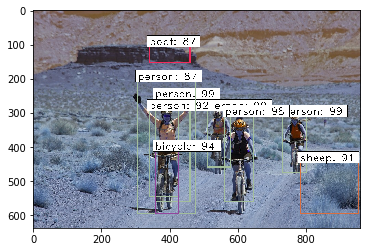

True

In [44]:
# 600,902 > 630,960으로 바꾼다.
def get_real_coordinates(ratio, x1, y1, x2, y2):
    real_x1 = int(round(x1 // ratio))
    real_y1 = int(round(y1 // ratio))
    real_x2 = int(round(x2 // ratio))
    real_y2 = int(round(y2 // ratio))
    return (real_x1, real_y1, real_x2 ,real_y2)

# opencv로 물체들의 위치와 라벨을 그려준다.
all_dets = []

for key in bboxes:
    bbox = np.array(bboxes[key])
    prob = np.array(probs[key])
    print('before',bbox.shape, prob.shape)
    new_boxes, new_probs = roi_helpers.non_max_suppression_fast(bbox, prob, overlap_thresh=0.5)
    print('after',new_boxes.shape, new_probs.shape)
    for jk in range(new_boxes.shape[0]):
        (x1, y1, x2, y2) = new_boxes[jk,:]

        (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

        cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),2)

        textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
        all_dets.append((key,100*new_probs[jk]))

        (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
        textOrg = (real_x1, real_y1-0)

        cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
        cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
        cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

# st = time.time()
# print('Elapsed time = {}'.format(time.time() - st))
print(all_dets)
plt.imshow(img)
plt.show()
cv2.imwrite('1.png',img)